# Env

In [ ]:
import argparse
import random

import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
# 학습환경 설정
args = {
    # random seed value
    "seed": 1234,
    # number of epoch
    "n_epoch": 200,
    # number of batch
    "n_batch": 2,
    # learning rate
    "lr": 0.001,
    # weights 저장 위치
    "save_path": "01-02-sentence-prediction.pth",
    # CPU 또는 GPU 사용여부 결정
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}
args = argparse.Namespace(**args)

print(args)

Namespace(device=device(type='cpu'), lr=0.001, n_batch=2, n_epoch=200, save_path='01-02-sentence-prediction.pth', seed=1234)


In [ ]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

# Data

In [ ]:
# 입력 문장
raw_inputs = [
    "나는 학생 입니다",
    "나는 좋은 선생님 입니다",
    "당신은 매우 좋은 선생님 입니다"
]

In [ ]:
# 정답: 학생(1), 기타(0)
raw_labels = [1, 0, 0]

# Vocabulary

In [ ]:
# 문장을 띄어쓰기단위로 분할
words = []
for s in raw_inputs:
    words.extend(s.split())

print(words)

['나는', '학생', '입니다', '나는', '좋은', '선생님', '입니다', '당신은', '매우', '좋은', '선생님', '입니다']


In [ ]:
# 중복단어 제거
words = list(dict.fromkeys(words))

print(words)

['나는', '학생', '입니다', '좋은', '선생님', '당신은', '매우']


In [ ]:
# 각 단어별 일련번호
word_to_id = {"[PAD]": 0, "[UNK]": 1}
for w in words:
    word_to_id[w] = len(word_to_id)

print(word_to_id)

{'[PAD]': 0, '[UNK]': 1, '나는': 2, '학생': 3, '입니다': 4, '좋은': 5, '선생님': 6, '당신은': 7, '매우': 8}


In [ ]:
# 각 번호별 단어
id_to_word = {i: w for w, i in word_to_id.items()}

print(id_to_word)

{0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '학생', 4: '입니다', 5: '좋은', 6: '선생님', 7: '당신은', 8: '매우'}


# 학습 및 평가용 데이터 생성

In [ ]:
# 입력 데이터
inputs = []
for s in raw_inputs:
    inputs.append([word_to_id[w] for w in s.split()])
    
print(inputs)

[[2, 3, 4], [2, 5, 6, 4], [7, 8, 5, 6, 4]]


In [ ]:
# 정답 데이터
labels = raw_labels

print(labels)

[1, 0, 0]


In [ ]:
class SimpleDataSet(torch.utils.data.Dataset):
    """ 데이터셋 클래스 """

    def __init__(self, inputs, labels):
        """
        생성자
        :param inputs: 입력
        :param labels: 정답
        """
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        """ 데이터셋 길이 """
        assert len(self.inputs) == len(self.labels)
        return len(self.labels)

    def __getitem__(self, index):
        """
        데이터 한 개 조회
        :param index: 데이터 위치
        """
        return (
            torch.tensor(self.inputs[index]),
            torch.tensor(self.labels[index]),
        )

    def collate_fn(self, batch):
        """
        batch단위로 데이터 처리
        :param batch: batch 단위 데이터
        """
        inputs, labels = list(zip(*batch))

        inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
        labels = torch.stack(labels)

        batch = [
            inputs,
            labels,
        ]

        return batch

In [ ]:
# dataset
dataset = SimpleDataSet(inputs, labels)

print(len(dataset))

3


In [ ]:
# random sample data
sampler = torch.utils.data.RandomSampler(dataset)

In [ ]:
# train loader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=args.n_batch, sampler=sampler, collate_fn=dataset.collate_fn)

In [ ]:
# dataset
dataset = SimpleDataSet(inputs, labels)
# valid loader
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=args.n_batch, sampler=None, collate_fn=dataset.collate_fn)

In [ ]:
# dataset
dataset = SimpleDataSet(inputs, labels)
# test loader
test_loader = torch.utils.data.DataLoader(dataset, batch_size=args.n_batch, sampler=None, collate_fn=dataset.collate_fn)

# 모델링

## Tutorial

In [ ]:
# model tutorial 입력
t_inputs = torch.tensor(inputs[:1])
t_labels = torch.tensor(labels[:1])

print(t_inputs, t_labels)

tensor([[2, 3, 4]]) tensor([1])


In [ ]:
# 단어 일련번호를 단어 벡터로 변환
embed = torch.nn.Embedding(len(word_to_id), 4)
hidden = embed(t_inputs)

print(hidden.shape, hidden)

torch.Size([1, 3, 4]) tensor([[[-0.2153,  0.8840, -0.7584, -0.3689],
         [-0.3424, -1.4020,  0.3206, -1.0219],
         [ 0.7988, -0.0923, -0.7049, -1.6024]]], grad_fn=<EmbeddingBackward>)


In [ ]:
# RNN, CNN, Attention 등 다양한 NN 실행

In [ ]:
# 단어를 특징 중 최대값을 문장의 특징으로 사용
hidden, _ = torch.max(hidden, dim=1)

print(hidden.shape, hidden)

torch.Size([1, 4]) tensor([[ 0.7988,  0.8840,  0.3206, -0.3689]], grad_fn=<MaxBackward0>)


In [ ]:
# 문장 학생(1) 또는 기타(0) 예측
linear = torch.nn.Linear(4, 2)
logits = linear(hidden)

print(logits.shape, logits)

torch.Size([1, 2]) tensor([[-0.6278,  0.5786]], grad_fn=<AddmmBackward>)


In [ ]:
# CrossEntropy loss 계산
loss_fn = torch.nn.CrossEntropyLoss()
loss = loss_fn(logits.view(-1, logits.size(-1)), t_labels.view(-1))

print(loss)

tensor(0.2618, grad_fn=<NllLossBackward>)


## Class

In [ ]:
class SentencePrediction(torch.nn.Module):
    """ 문장단위 예측 모델 """

    def __init__(self, n_vocab):
        """
        생성자
        :param n_vocab: number of vocab
        """
        super().__init__()
        self.embed = torch.nn.Embedding(n_vocab, 4)
        self.linear = torch.nn.Linear(4, 2)

    def forward(self, inputs):
        """
        모델 실행
        :param inputs: input data
        """
        hidden = self.embed(inputs)
        hidden, _ = torch.max(hidden, dim=1)
        logits = self.linear(hidden)
        return logits

In [ ]:
# 학습용 모델 생성
model = SentencePrediction(len(word_to_id))
model.to(args.device)

print(model)

SentencePrediction(
  (embed): Embedding(9, 4)
  (linear): Linear(in_features=4, out_features=2, bias=True)
)


# 학습

In [ ]:
# loss & optimizer 생성
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

In [ ]:
def accuracy_fn(logits, labels):
    """
    model accuracy 측정
    :param logits: 예측 값
    :param labels: 정답
    """
    # 값이 최대인 index 값
    _, indices = logits.max(-1)
    # label과 비교
    matchs = torch.eq(indices, labels).cpu().numpy()
    total = np.ones_like(matchs)
    acc_val = np.sum(matchs) / max(1, np.sum(total))
    return acc_val

In [ ]:
def train_epoch(args, model, loader, loss_fn, optimizer):
    """
    1 epoch 학습
    :param args: 입력 arguments
    :param model: 모델
    :param loader: 데이터로더
    :param loss_fn: loss 계산함수
    :param optimizer: optimizer
    """
    # model을 train 모드로 전환
    model.train()
    # loss 및 accuracy 저장
    losses, access = [], []
    # data loader에서 batch단위로 처리
    for batch in loader:
        # optimizer 초기화
        optimizer.zero_grad()
        # batch 입력값 처리 (CPU or GPU)
        inputs, labels = map(lambda v: v.to(args.device), batch)
        # 모델 실행
        logits = model(inputs)
        # loss 계산
        loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
        loss.backward()
        # model weight 변경
        optimizer.step()
        # loss 저장
        loss_val = loss.item()
        losses.append(loss_val)
        # accuracy 계산 및 저장
        acc_val = accuracy_fn(logits, labels)
        access.append(acc_val)

    return np.mean(losses), np.mean(access)

In [ ]:
def eval_epoch(args, model, loader, loss_fn):
    """
    1 epoch 평가
    :param args: 입력 arguments
    :param model: 모델
    :param loader: 데이터로더
    :param loss_fn: loss 계산함수
    """
    # model을 eval 모드로 전환
    model.eval()
    # loss 및 accuracy 저장
    losses, access = [], []
    # 실행시에 gradint 계산 비활성화
    with torch.no_grad():
        for batch in loader:
            # batch 입력값 처리 (CPU or GPU)
            inputs, labels = map(lambda v: v.to(args.device), batch)
            # 모델 실행
            logits = model(inputs)
            # loss 계산
            loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
            # loss 저장
            loss_val = loss.item()
            losses.append(loss_val)
            # accuracy 계산 및 저장
            acc_val = accuracy_fn(logits, labels)
            access.append(acc_val)

    return np.mean(losses), np.mean(access)

In [ ]:
# 학습 history
history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
# 가장 좋은 acc 값
best_acc = 0

In [ ]:
# 학습 및 평가
for e in range(args.n_epoch):
    train_loss, train_acc = train_epoch(args, model, train_loader, loss_fn, optimizer)
    valid_loss, valid_acc = eval_epoch(args, model, valid_loader, loss_fn)
    # 학습 history 저장
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["valid_loss"].append(valid_loss)
    history["valid_acc"].append(valid_acc)
    # 학습과정 출력
    print(f"eopch: {e + 1:3d}, train_loss: {train_loss:.5f}, train_acc: {train_acc: .5f}, valid_loss: {valid_loss:.5f}, valid_acc: {valid_acc:.5f}")
    # best weight 저장
    if best_acc < valid_acc:
        best_acc = valid_acc
        # 저장
        torch.save(
            {"state_dict": model.state_dict(), "valid_acc": valid_acc},
            args.save_path,
        )
        # 저장내용 출력
        print(f"  >> save weights: {args.save_path}")

eopch:   1, train_loss: 0.69832, train_acc:  0.25000, valid_loss: 0.69427, valid_acc: 0.75000
eopch:   2, train_loss: 0.74814, train_acc:  0.50000, valid_loss: 0.68883, valid_acc: 0.75000
eopch:   3, train_loss: 0.68679, train_acc:  0.75000, valid_loss: 0.68342, valid_acc: 0.75000
eopch:   4, train_loss: 0.30122, train_acc:  1.00000, valid_loss: 0.67798, valid_acc: 0.75000
eopch:   5, train_loss: 0.73208, train_acc:  0.50000, valid_loss: 0.67305, valid_acc: 0.75000
eopch:   6, train_loss: 0.72719, train_acc:  0.50000, valid_loss: 0.66808, valid_acc: 0.75000
eopch:   7, train_loss: 0.29173, train_acc:  1.00000, valid_loss: 0.66309, valid_acc: 0.75000
eopch:   8, train_loss: 0.66125, train_acc:  0.75000, valid_loss: 0.65849, valid_acc: 0.75000
eopch:   9, train_loss: 0.71284, train_acc:  0.50000, valid_loss: 0.65377, valid_acc: 0.75000
eopch:  10, train_loss: 0.65189, train_acc:  0.75000, valid_loss: 0.64906, valid_acc: 0.75000
eopch:  11, train_loss: 0.27994, train_acc:  1.00000, valid_

In [ ]:
def draw_history(history):
    """
    학습과정 그래프 출력
    :param history: 학습 이력
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], "b-", label="train_loss")
    plt.plot(history["valid_loss"], "r--", label="valid_loss")
    plt.xlabel("Epoch")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], "k--", label="train_acc")
    plt.plot(history["valid_acc"], "k--", label="valid_acc")
    plt.xlabel("Epoch")
    plt.legend()

    plt.show()

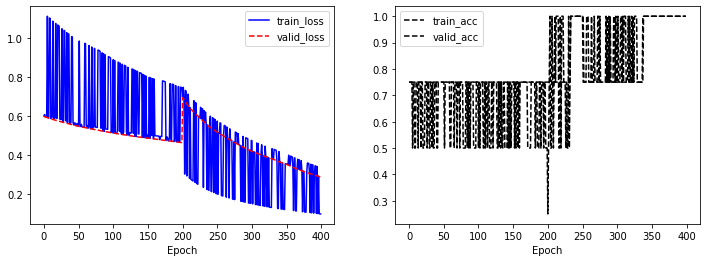

In [ ]:
# 학습과정 그래프 출력
draw_history(history)

# 테스트

In [ ]:
# 테스트용 모델 생성
model = SentencePrediction(len(word_to_id))
model.to(args.device)

print(model)

SentencePrediction(
  (embed): Embedding(9, 4)
  (linear): Linear(in_features=4, out_features=2, bias=True)
)


In [ ]:
# 랜덤 초기화 모델 평가
valid_loss, valid_acc = eval_epoch(args, model, test_loader, loss_fn)

print(valid_loss, valid_acc)

0.752669632434845 0.25


In [ ]:
# 저장된 데이터 로드
save_dict = torch.load(args.save_path)

print(save_dict)

{'state_dict': OrderedDict([('embed.weight', tensor([[ 2.5778,  0.6080, -0.0840, -1.1623],
        [-0.7324, -0.3980, -0.2705, -1.9422],
        [-0.3898,  0.5603,  0.4599, -1.2823],
        [-0.2596,  0.0841,  0.1379,  1.8627],
        [-0.5309,  1.1335, -0.5636, -1.6085],
        [ 0.9946,  0.7637, -0.4822, -0.3099],
        [ 1.2101, -0.3155, -0.7717,  0.4705],
        [-1.3201, -0.4313, -0.1156,  0.4851],
        [-2.3366, -0.8358,  1.6331,  0.3221]])), ('linear.weight', tensor([[ 0.3424, -0.1843,  0.2478, -0.4757],
        [-0.4902,  0.2471, -0.2083,  0.4326]])), ('linear.bias', tensor([0.0099, 0.3005]))]), 'valid_acc': 1.0}


In [ ]:
# 학습된 weights로 모델 초기화
model.load_state_dict(save_dict['state_dict'])

<All keys matched successfully>

In [ ]:
# 학습된 weights로 초기화 모델 평가
valid_loss, valid_acc = eval_epoch(args, model, test_loader, loss_fn)

print(valid_loss, valid_acc)

0.5623021721839905 1.0


# 배포

In [ ]:
# 배포용 모델 생성
model = SentencePrediction(len(word_to_id))
model.to(args.device)

# 저장된 데이터 로드
save_dict = torch.load(args.save_path)

# 학습된 weights로 모델 초기화
model.load_state_dict(save_dict['state_dict'])

<All keys matched successfully>

In [ ]:
def do_predict(word_to_id, model, string):
    """
    입력에 대한 답변 생성하는 함수
    :param word_to_id: vocabulary
    :param model: model
    :param string: 입력 문자열
    """
    # token 생성
    token = [word_to_id[w] for w in string.strip().split()]

    model.eval()
    with torch.no_grad():
        inputs = torch.tensor([token]).to(args.device)
        logits = model(inputs)
        _, indices = logits.max(-1)
        y_pred = indices[0].numpy()
    result = "학생" if y_pred == 1 else "기타"
    return result

In [ ]:
# 예측 실행
do_predict(word_to_id,model, "당신은 선생님 입니다")

'학생'